# Algorithms Project: The Big Heist
by Pavel Borovikov

> #### Objective:
> Using the provided data from *bank_data.csv*, **aquire as much money as possible** from the banks in **under 24 hours**. The time to rob and money earned is available in the provided data. The hypothetical car that will be used during the heist travels at a speed of 30*km/h*. The car can start at any bank, but must end it's travels at the point of origin (0,0).

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist, squareform
from utils.algorithms import nearest_neighbour_path, inc_nearest_neighbour_path
from utils.check_solution import check_solution

In [2]:
df = pd.read_csv('data/bank_data.csv')
print("Total money available: ", df['money'].sum())
print("Total time to rob all the banks: ", df['time (hr)'].sum())
df.describe()

Total money available:  184303200
Total time to rob all the banks:  7502.450028524693


,id,x_coordinate,y_coordinate,money,time (hr)
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,-0.016431,0.037561,18430.320000,0.750245
std,2886.89568,2.889568,2.881789,25382.131155,0.433541
min,0.00000,-4.999292,-4.999928,100.000000,0.000032
25%,2499.75000,-2.513854,-2.415033,900.000000,0.373141
50%,4999.50000,-0.024904,0.010442,5800.000000,0.749218
75%,7499.25000,2.461754,2.540303,26900.000000,1.122812
max,9999.00000,4.999851,4.999626,102300.000000,1.499851


The data provided contains a unique id for each of the 10 000 banks, which will later be used to create a route.

<br>

#### Columns :

    id : unique integer id for the bank
    x_coordinate : x coordinate of the bank
    y_coordinate : y coordinate of the bank
    money : total gains from the bank
    time (hr) : total time necessary to rob the bank

<br>

#### Things to note:

- The minimum and maximum of the x and y coordinates show that the banks spread around an area of about $100km^{2}$.

- There are big differences between the minimum amounts of money and time compared to their respective maximum.

- The total amount of gains possible is 184 303 200$, the time it would take to rob that is 7 502.45 hours.

- Each bank on average has about 18 000$ and would take on average 0.75h each to rob. 

Considering these facts, without accounting for driving distance, the car would visit about 32 banks and escape with a total of about 576 000$ if the average banks were targeted.

<br>

> Due to there being only 24 hours available for the heist, it would be impossible to rob all of the banks. The banks must go through some selection process in order to obtain as much money as possible within 24 hours.
>
> **To get a better understanding of the data, the following columns will be added:**<br>
> > **day percent** : the percentage of the total 24h that it would take to rob the bank.<br><br>
> > **score** : the score dividing the money gained per hour by the percentage of the day that it will take.

In [3]:
df['day percent'] = (df['time (hr)'] / 24) * 100
df['score'] = df['money'] / df['day percent']
print("Minimum score : ", df['score'].min())
print("Maximum score : ", df['score'].max())

Minimum score :  16.00409676564774
Maximum score :  70310476.15889467


Due to the big difference in score, a logarithm is applied to achieve a smaller range.

In [4]:
df['score'] = np.log(df['score'])
print("Minimum score : ", df['score'].min())
print("Maximum score : ", df['score'].max())

Minimum score :  2.772844737318108
Maximum score :  18.06843136643082


The values of the scores are arbitrary, however, the higher the score, the more worthy a bank is.
Because the score takes into account what percentage of the day a bank will take to rob, the score will favor really small robbing times with really high monetary gains. 

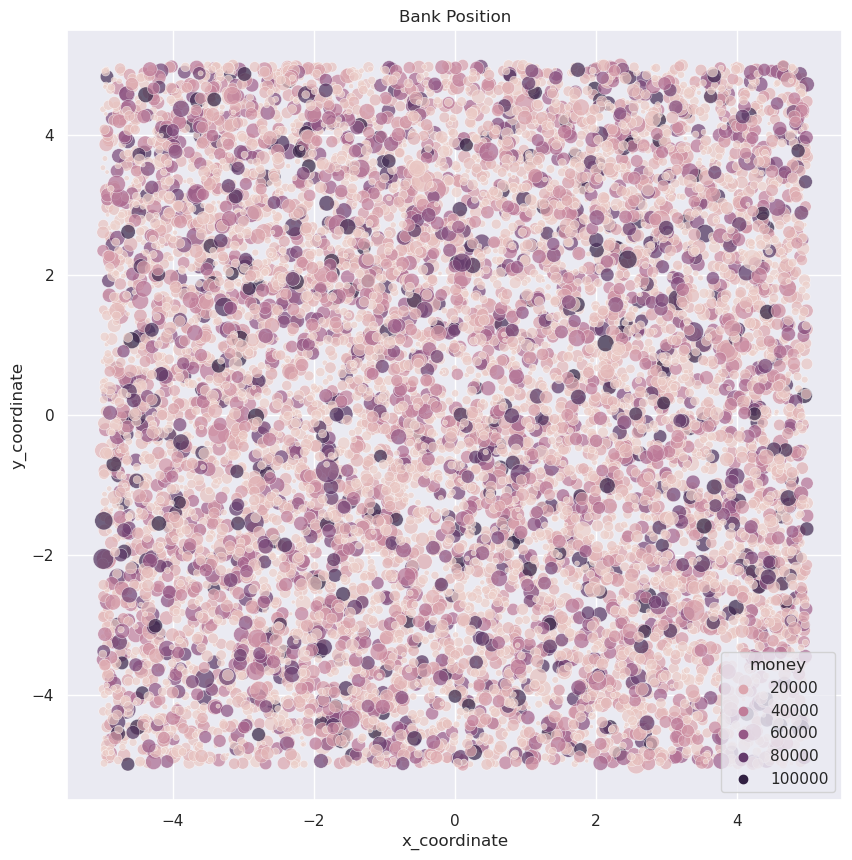

In [9]:
sns.scatterplot(x=df['x_coordinate'], y=df['y_coordinate'], hue=df['money'], s=df['score']**2, alpha=0.7);
plt.title('Bank Position');
sns.set(rc={'figure.figsize':(10, 10)});

- The scatter plot above shows the positions of each banks with a **circle**.<br>

- The **gradiant** of color represents **money** earned from the bank.<br>

- The **size** of each circle represent the bank's **score** relative to eachother. The score was set to the second power in order to make the sizes more visible in the plot.

#### Observations: 

The banks appear to be spread out randomly throughout the entire area. The most profitable banks and those with higher scores also appear to be spread randomly. While there could be a way to prove that there is no concentration of valuable banks, the first trial for this project will assume they are evenly spread focus on banks above a certain score, also assuming that the car will travel the entire area available.

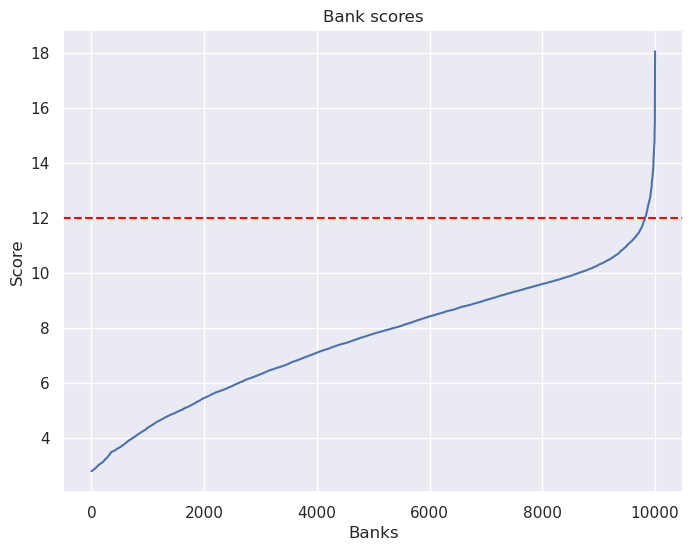

In [11]:
sorted_scores = df['score'].sort_values()
x = np.arange(len(df['score']))

plt.plot(x, sorted_scores)
plt.title('Bank scores')
plt.xlabel('Banks')
plt.ylabel('Score')
plt.axhline(12, linestyle='--', c='red')
sns.set(rc={'figure.figsize':(8, 6)})
plt.show()

**The graph above shows that there are a smaller amount of banks have a significantly higher score than others.**

Banks that have a score 12 above will be the best for high profit in a short amount of time.

Total money: 9167200
Time to rob:  6.498374831828951
Total amount banks:  178


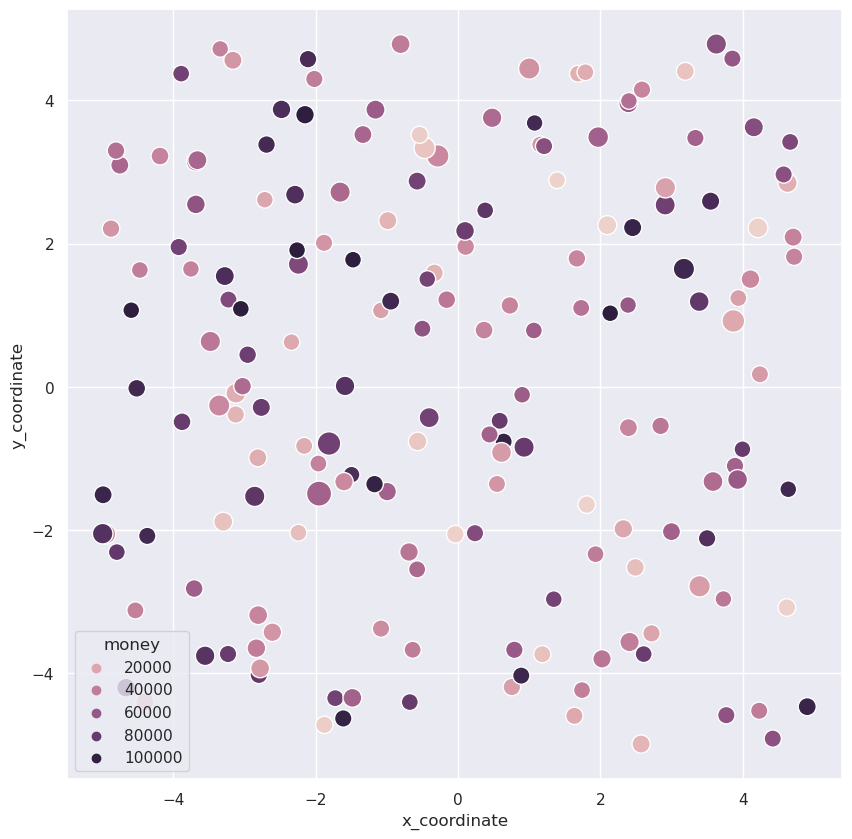

In [13]:
best = df.loc[(df['score'] >= 12)]

sns.scatterplot(x=best['x_coordinate'], y=best['y_coordinate'], hue=best['money'], s=best['score']**2)

print('Total money:', best['money'].sum())
print('Time to rob: ', best['time (hr)'].sum())
print('Total amount banks: ', len(best))
sns.set(rc={'figure.figsize':(10, 10)});
plt.show()

### Hypothesis

Based on these selected banks, it is likely that the vehicle will need to travel through the entirety of the area. The banks with the best scores will take about 6.5 hours to rob and the gains will be at least 9 million. <br>

These number appear to be much better than the average case of an approximate 576 000$ and 24 hours to rob, which shows that the scoring method was effective.

The most optimal solution could be found in time complexity $O(n!)$, however there are 178 best banks and potentially more, as long as travel time and rob time adds up to less than 24 hours, the most optimal solution will go through an insanely large amount of calculations.

This project will use a nearest neighbour algorithm of best case complexity $O(n^{2})$, while the solution will not be optimal, it will be a relatively quick way to solve this problem.

It is hard to guess or even approximate the travel time before the nearest neighbour solution, therefore the solution will create multiple routes, adding banks with lower scores until the 24 hour time limit is met. Due to this factor, the complexity of the solution will look more like $O(xn^{2})$, x being the number of times the nearest neighbour algorithm is repeated, which gets less significant as n becomes really large.

In [19]:
# incrementing nearest neighbour algorithm
# uses O(n^2) algorithm multiple times until the 24 hour limit is reached
path_info = inc_nearest_neighbour_path(df, start=12, increments=-0.01)
best_route = path_info.pop('best_route')
print(path_info)

{'money_earned': 15126100.0, 'time_remaining': '0.03 hours', 'banks_visited': 293, 'lowest_bank_score': 11.43, 'total_path_length': 155.98}


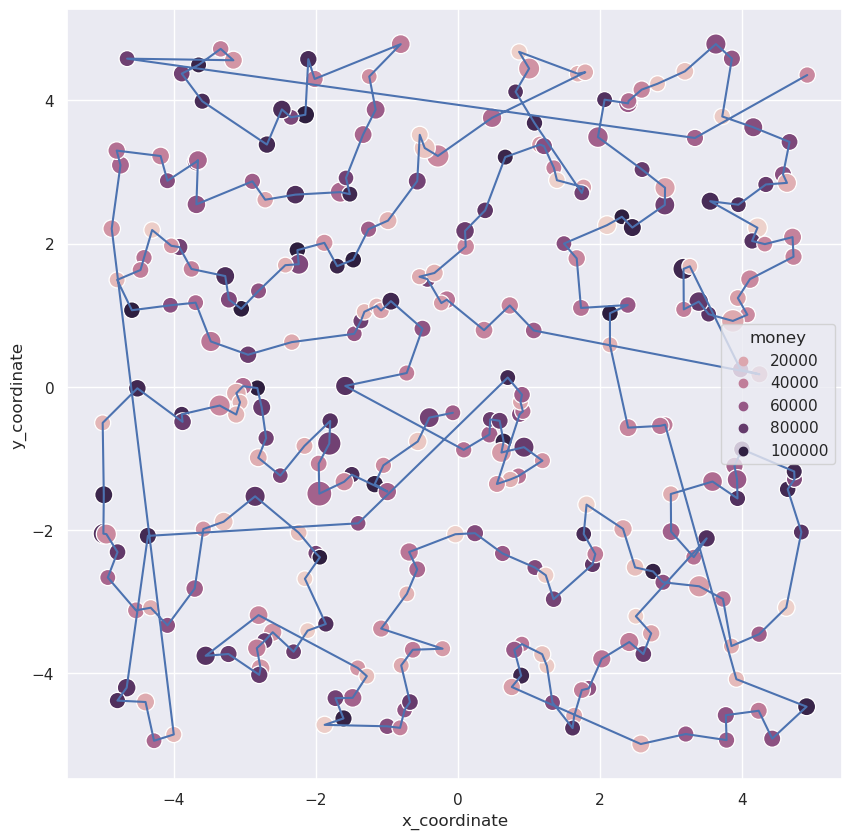

Total path length:  155.98km
Total time with a speed of 30km/h : 5.2 hours


In [29]:
best_df = df.iloc[best_route]


speed = 30 # km / hour
travel_time = path_info['total_path_length'] / speed


sns.scatterplot(x=best_df['x_coordinate'], y=best_df['y_coordinate'], hue=best_df['money'], s=best_df['score']**2)
plt.plot(best_df['x_coordinate'], best_df['y_coordinate'])
plt.show()

print(f"Total path length:  {path_info['total_path_length']}km")
print(f"Total time with a speed of {speed}km/h : {round(travel_time,2)} hours")

## Conclusion :

The solution was obtained using the nearest neighbour approach after applying a scoring system to the banks.

    Total gains : 15 126 100$
    Time remaining : 0.033 hours


The total monetary gains are at least **26 times higher** than if only the **average banks** were targeted.


To a human eye, the shortest path found by the nearest neighbour algorithm appears to have a lot of room for improvement. Some paths between banks appear to be long and sometimes go back and forth through a significant distance while intersecting other paths. One way to improve this would be to reevaluate each path, starting from the longest paths, find closer neighbours for those paths, and create detours by modifying other neighbouring paths. However, due to the scoring system, if higher score banks have priority over lower scores, the total amount of money gained would be below 17 million, not including travel time.

Depending on the amount of travel time it is possible to save, the profits could raise slightly, however, those gains will be relatively small. With the current scoring system, the current monetary gains maximum of 15 126 100$ could be improved by at most 13% if travel distance was not accounted for. If it were possible to save an hour during travel time, the total monatery gains could improve by approximately 2%. The travel time would have to be at least an approximate 3 hours if the entire area is to be travelled. That said, the total gains would increase between an approximate 2-4% 

In [88]:
high_lim = 11.451
low_lim = 11.36

potential_best = df[df['score'] >= low_lim].sort_values('score', ascending=False)
potential_best['total money'] = potential_best['money'].cumsum()
potential_best['total time'] = potential_best['time (hr)'].cumsum()

# percentage increase from the total money earned from solution 
potential_best['percent increase'] = potential_best['total money'] / path_info['money_earned'] * 100 - 100

chunk = potential_best[potential_best['score'] <= high_lim]

chunk[['score', 'total money', 'total time', 'percent increase']]

,score,total money,total time,percent increase
1398,11.450897,15126100,18.535540,0.000000
9804,11.449830,15188700,18.695565,0.413854
9081,11.444140,15217200,18.768836,0.602270
2568,11.436702,15219900,18.775829,0.620120
5012,11.435256,15269200,18.903705,0.946047
6660,11.434600,15290700,18.959509,1.088185
3917,11.430070,15329900,19.061716,1.347340
6653,11.429990,15424100,19.307346,1.970105
4629,11.429959,15452900,19.382445,2.160504
6979,11.425873,15456700,19.392394,2.185626
